## Explanations below

In [1]:
import os
import shutil
import pandas as pd

# Define the source and destination folders
source_folder = '../5_Data_Pipeline/time_sets_st_shortened'
destination_folder = '../5_Data_Pipeline/input/under_way_sailing'

# Ensure destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate over each file in the source folder
for filename in os.listdir(source_folder):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(source_folder, filename)
        
        # Try to read the CSV file
        try:
            df = pd.read_csv(file_path)

            # Check if 'Navigational status' column exists and contains the value 'Underway sailing'
            if 'Navigational status' in df.columns and 'Under way sailing' in df['Navigational status'].values:
                # If the condition is met, copy the file to the destination folder
                shutil.copy(file_path, os.path.join(destination_folder, filename))
                print(f"Copied: {filename}")
        except Exception as e:
            print(f"Could not process {filename}: {e}")

print("Script execution completed.")


Copied: filtered_211210280_20240610_0622-20240610_0637_standardized_10s.csv
Copied: filtered_211210280_20240610_0652-20240610_0707_standardized_10s.csv
Copied: filtered_211210280_20240610_0707-20240610_0722_standardized_10s.csv
Copied: filtered_211210280_20240610_0752-20240610_0807_standardized_10s.csv
Copied: filtered_211210280_20240610_0837-20240610_0852_standardized_10s.csv
Copied: filtered_211210280_20240610_0852-20240610_0907_standardized_10s.csv
Copied: filtered_211210280_20240610_0907-20240610_0922_standardized_10s.csv
Copied: filtered_211210280_20240610_0922-20240610_0937_standardized_10s.csv
Copied: filtered_211210280_20240610_0937-20240610_0952_standardized_10s.csv
Copied: filtered_211215170_20240530_0547-20240530_0602_standardized_10s.csv
Copied: filtered_211215170_20240530_0602-20240530_0617_standardized_10s.csv
Copied: filtered_211215170_20240530_0617-20240530_0632_standardized_10s.csv
Copied: filtered_211215170_20240530_0632-20240530_0647_standardized_10s.csv
Copied: filt

X_train: (35712, 60, 5), X_val: (8928, 60, 5), X_test: (11160, 60, 5)
Epoch 1/200
1116/1116 [==============================] - 20s 16ms/step - loss: 0.6775 - accuracy: 0.5736 - val_loss: 0.6776 - val_accuracy: 0.5743
Epoch 2/200
1116/1116 [==============================] - 17s 15ms/step - loss: 0.6492 - accuracy: 0.6362 - val_loss: 0.6507 - val_accuracy: 0.6268
Epoch 3/200
1116/1116 [==============================] - 15s 13ms/step - loss: 0.6380 - accuracy: 0.6458 - val_loss: 0.6274 - val_accuracy: 0.6567
Epoch 4/200
1116/1116 [==============================] - 12s 11ms/step - loss: 0.6232 - accuracy: 0.6611 - val_loss: 0.6195 - val_accuracy: 0.6639
Epoch 5/200
1116/1116 [==============================] - 17s 15ms/step - loss: 0.6049 - accuracy: 0.6787 - val_loss: 0.5935 - val_accuracy: 0.6849
Epoch 6/200
1116/1116 [==============================] - 10s 9ms/step - loss: 0.5819 - accuracy: 0.6965 - val_loss: 0.5746 - val_accuracy: 0.7051
Epoch 7/200
1116/1116 [==========================

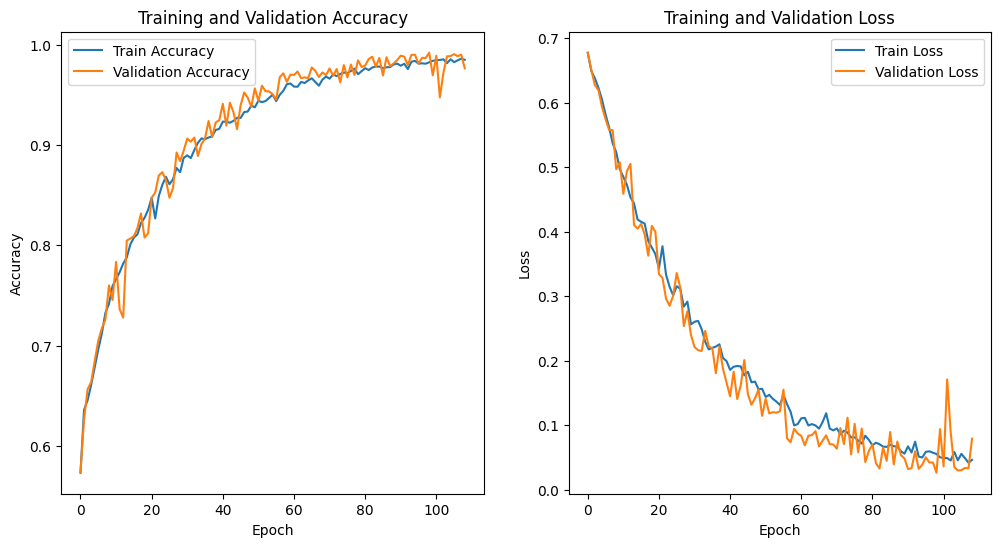

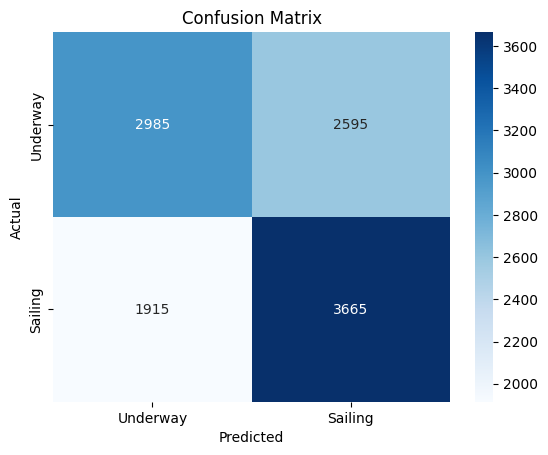

              precision    recall  f1-score   support

           0       0.61      0.53      0.57      5580
           1       0.59      0.66      0.62      5580

    accuracy                           0.60     11160
   macro avg       0.60      0.60      0.59     11160
weighted avg       0.60      0.60      0.59     11160



In [4]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to the folders
folder_underway = "../5_Data_Pipeline/input/underway_using_engine"
folder_sailing = "../5_Data_Pipeline/input/under_way_sailing"

# Parameters
sequence_length = 60  # Length of time sequences (1 hour if sampled every minute)
features = ['SOG', 'COG', 'Heading']  # Columns to use as features
num_samples = 900  # Number of files to use per category (undersampling)

# Function to randomly select files for undersampling
def get_sampled_files(folder, num_samples):
    all_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
    return random.sample(all_files, min(num_samples, len(all_files)))

# Function to load and preprocess data
def load_and_preprocess_data(folder, file_list, label, sequence_length, features):
    data = []
    labels = []
    file_origins = []
    for file in file_list:
        df = pd.read_csv(os.path.join(folder, file))
        
        # Normalize SOG
        scaler = MinMaxScaler()
        df['SOG'] = scaler.fit_transform(df[['SOG']])
        
        # Encode COG and Heading cyclically
        df['COG_x'] = np.sin(np.radians(df['COG']))
        df['COG_y'] = np.cos(np.radians(df['COG']))
        df['Heading_x'] = np.sin(np.radians(df['Heading']))
        df['Heading_y'] = np.cos(np.radians(df['Heading']))
        
        # Select features
        feature_columns = ['SOG', 'COG_x', 'COG_y', 'Heading_x', 'Heading_y']
        df = df[feature_columns]
        
        # Create sequences
        for i in range(len(df) - sequence_length + 1):
            sequence = df.iloc[i:i + sequence_length].values
            data.append(sequence)
            labels.append(label)
            file_origins.append(file)  # Track the file name for this sequence
    return np.array(data), np.array(labels), np.array(file_origins)

# Step 1: Select a balanced subset of files
files_underway = get_sampled_files(folder_underway, num_samples)
files_sailing = get_sampled_files(folder_sailing, num_samples)

# Step 2: Create a file-level split (to avoid sequences from the same file in train and test sets)
file_list = np.array(files_underway + files_sailing)
file_labels = np.array([0] * len(files_underway) + [1] * len(files_sailing))

files_train, files_test, y_train_files, y_test_files = train_test_split(
    file_list, file_labels, test_size=0.2, stratify=file_labels, random_state=42
)

# Step 3: Load sequences for training and testing
data_train, labels_train, files_train_seq = load_and_preprocess_data(folder_underway, files_train[y_train_files == 0], 0, sequence_length, features)
data_sailing_train, labels_sailing_train, files_sailing_train_seq = load_and_preprocess_data(folder_sailing, files_train[y_train_files == 1], 1, sequence_length, features)

data_test, labels_test, files_test_seq = load_and_preprocess_data(folder_underway, files_test[y_test_files == 0], 0, sequence_length, features)
data_sailing_test, labels_sailing_test, files_sailing_test_seq = load_and_preprocess_data(folder_sailing, files_test[y_test_files == 1], 1, sequence_length, features)

# Step 4: Combine training and testing data
X_train = np.concatenate([data_train, data_sailing_train], axis=0)
y_train = np.concatenate([labels_train, labels_sailing_train], axis=0)
files_train_seq = np.concatenate([files_train_seq, files_sailing_train_seq], axis=0)

X_test = np.concatenate([data_test, data_sailing_test], axis=0)
y_test = np.concatenate([labels_test, labels_sailing_test], axis=0)
files_test_seq = np.concatenate([files_test_seq, files_sailing_test_seq], axis=0)

# Step 5: Split off validation set from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Debugging: Print data shapes
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict probabilities and binary labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')

# Misclassification Analysis
results = pd.DataFrame({
    'file': files_test_seq,
    'true_label': y_test,
    'predicted_label': y_pred.flatten()
})
results['misclassified'] = results['true_label'] != results['predicted_label']

misclassified_summary = results.groupby('file')['misclassified'].sum().reset_index()
misclassified_summary = misclassified_summary.sort_values(by='misclassified', ascending=False)

print("Files with the most misclassified sequences:")
print(misclassified_summary.head(10))

# Save misclassification summary
misclassified_summary.to_csv('misclassified_summary.csv', index=False)

# Visualization Functions
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Underway', 'Sailing'], yticklabels=['Underway', 'Sailing'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_learning_curve(history)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [3]:
# Save the model
model.save("navstat_classifier_binary_sail.h5")

# Explanation:

### 1. **Loading CSV Files from the Folder:**
   - The function loops through the CSV files in the given folder, one by one. It reads each CSV file using `pandas.read_csv()` and processes the data. 
   - These CSV files contain the vessel's movement data with columns like `SOG`, `COG`, and `Heading`.

   **Example of data loaded from a CSV file:**

   | Timestamp | SOG | COG  | Heading |
   |-----------|-----|------|---------|
   | 00:00     | 5.4 | 45   | 60      |
   | 00:01     | 5.6 | 47   | 61      |
   | 00:02     | 5.7 | 50   | 62      |
   | ...       | ... | ...  | ...     |

   Here, **SOG** is the speed of the vessel, **COG** is the course (direction), and **Heading** is the heading angle.

### 2. **Normalization of `SOG` (Speed Over Ground):**
   - The `SOG` column is normalized using a `MinMaxScaler`, which scales all values to a range between 0 and 1.
   - **Normalization** is important because it brings different feature scales (e.g., speed vs. angle) to a similar range, making the training process more efficient.

   **Before normalization:**

   | Timestamp | SOG | COG  | Heading |
   |-----------|-----|------|---------|
   | 00:00     | 5.4 | 45   | 60      |
   | 00:01     | 5.6 | 47   | 61      |

   **After normalization:**

   The new values for `SOG` are calculated using:
   \[
   \text{Normalized SOG} = \frac{\text{SOG} - \text{min(SOG)}}{\text{max(SOG)} - \text{min(SOG)}}
   \]

   | Timestamp | Normalized SOG | COG  | Heading |
   |-----------|----------------|------|---------|
   | 00:00     | 0.00           | 45   | 60      |
   | 00:01     | 0.33           | 47   | 61      |

### 3. **Cyclic Encoding of `COG` and `Heading`:**
   - Both `COG` (Course Over Ground) and `Heading` are angular values, and as such, they have a **cyclic nature**: 0 degrees is the same as 360 degrees.
   - To properly handle this, **sine** and **cosine** transformations are applied:
     \[
     \text{COG}_x = \sin(\text{COG})
     \]
     \[
     \text{COG}_y = \cos(\text{COG})
     \]
     Similarly for `Heading`:
     \[
     \text{Heading}_x = \sin(\text{Heading})
     \]
     \[
     \text{Heading}_y = \cos(\text{Heading})
     \]
   - These transformations convert the angular values into two components that are easier for the model to learn from and capture cyclic relationships.

   **Example before and after cyclic encoding:**

   - **Before** (COG = 350 degrees, Heading = 10 degrees):
   
   | Timestamp | COG | Heading |
   |-----------|-----|---------|
   | 00:00     | 350 | 10      |

   - **After** (Apply sine and cosine transformations):
   
   | Timestamp | COG_x      | COG_y      | Heading_x  | Heading_y  |
   |-----------|------------|------------|------------|------------|
   | 00:00     | 0.1745     | 0.9848     | 0.1736     | 0.9848     |

### 4. **Selecting Relevant Features:**
   - After encoding the `COG` and `Heading`, the relevant features are selected: `SOG`, `COG_x`, `COG_y`, `Heading_x`, and `Heading_y`.
   - These features represent the vessel's speed and directional information in a form that the LSTM model can process.

   **Features selected for each time step:**

   | Timestamp | Normalized SOG | COG_x      | COG_y      | Heading_x  | Heading_y  |
   |-----------|----------------|------------|------------|------------|------------|
   | 00:00     | 0.00           | 0.1745     | 0.9848     | 0.1736     | 0.9848     |

### 5. **Creating Sequences:**
   - The LSTM model requires input data in the form of sequences (i.e., multiple time steps). Here, a sliding window approach is used to create sequences of `sequence_length` (e.g., 60 time steps).
   - For each sequence of 60 time steps, the features for those 60 steps are stacked into a 3D array (time steps, features per time step, and the number of sequences).
   - This helps the model learn patterns over time (e.g., how the vessel's behavior changes over an hour).

   **Example of sequences:**

   For a sequence length of 3, if the first 3 time steps look like this:
   
   | Timestamp | Normalized SOG | COG_x      | COG_y      | Heading_x  | Heading_y  |
   |-----------|----------------|------------|------------|------------|------------|
   | 00:00     | 0.00           | 0.1745     | 0.9848     | 0.1736     | 0.9848     |
   | 00:01     | 0.33           | 0.1736     | 0.9848     | 0.1732     | 0.9849     |
   | 00:02     | 0.50           | 0.1727     | 0.9850     | 0.1725     | 0.9850     |

   The model will receive a sequence of these 3 time steps as input for training.

### 6. **Labeling the Sequences:**
   - Each sequence is labeled with a binary value, depending on the activity of the vessel:
     - **0** for "underway using engine".
     - **1** for "engaged in fishing".
   - This label helps the model learn the relationship between the features and the vessel's activity.

### 7. **Loading and Combining Data:**
   - The function `load_and_preprocess_data` is called twice, once for the "underway" data and once for the "fishing" data.
   - After processing, the resulting feature arrays (`data_underway` and `data_fishing`) are concatenated together to form the complete dataset `X`, and their corresponding labels (`labels_underway` and `labels_fishing`) are concatenated to form the labels array `y`.

### Final Data Structure:
   After combining the data, you end up with:
   
   - **X**: A 3D array where each element represents a sequence of features (e.g., 60 time steps × 5 features per step = 300 features per sequence).
   
   - **y**: A 1D array with binary labels (0 or 1) indicating the vessel activity for each sequence.

---

### **Visualization of Sequences:**

Here’s how the sequences would look when plotted for `SOG`, `COG_x`, and `Heading_x` for a few time steps:

#### Example:

- **Sequence Data (3 time steps):**
  
  - `SOG`: [0.00, 0.33, 0.50]
  - `COG_x`: [0.1745, 0.1736, 0.1727]
  - `Heading_x`: [0.1736, 0.1732, 0.1725]


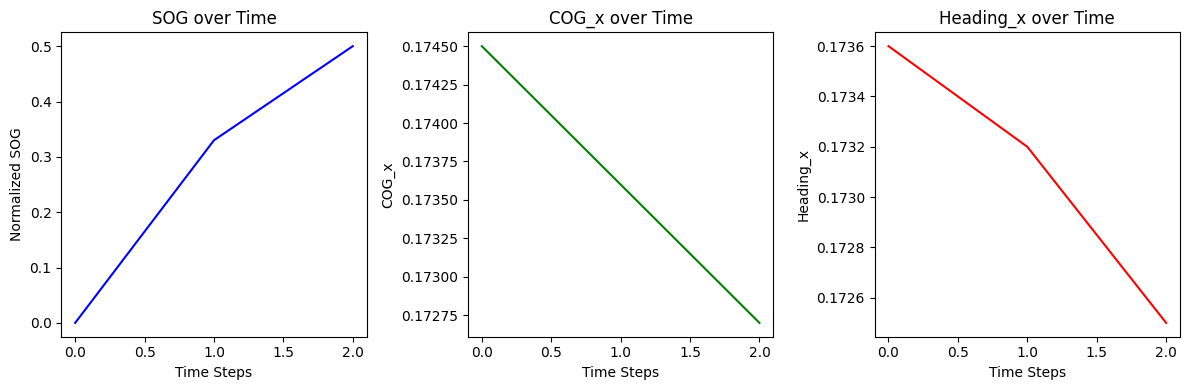

In [8]:
# Example sequences, like explained above.

import matplotlib.pyplot as plt

time_steps = [0, 1, 2]
SOG = [0.00, 0.33, 0.50]
COG_x = [0.1745, 0.1736, 0.1727]
Heading_x = [0.1736, 0.1732, 0.1725]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(time_steps, SOG, label="SOG", color="blue")
plt.title("SOG over Time")
plt.xlabel("Time Steps")
plt.ylabel("Normalized SOG")

plt.subplot(1, 3, 2)
plt.plot(time_steps, COG_x, label="COG_x", color="green")
plt.title("COG_x over Time")
plt.xlabel("Time Steps")
plt.ylabel("COG_x")

plt.subplot(1, 3, 3)
plt.plot(time_steps, Heading_x, label="Heading_x", color="red")
plt.title("Heading_x over Time")
plt.xlabel("Time Steps")
plt.ylabel("Heading_x")

plt.tight_layout()
plt.show()


### Sliding Window in Sequence Creation

In the current model setup, the **sliding window** approach is used to create sequences of a fixed length. This means that the **length of each sequence is constant** throughout the model's training process. 

### What is the Sliding Window Approach?

The sliding window technique extracts **overlapping sequences** from the raw time series data. The key idea is that the **window size** (i.e., the number of time steps per sequence) remains constant, and the window "slides" over the data to generate sequences. 

### Key Points:
1. **Fixed Sequence Length**: 
   - The length of each sequence remains **constant**. In this case, the sequence length is defined by the `sequence_length` parameter (e.g., 60 time steps).
   - This means every sequence the model receives has exactly the same number of time steps, no matter where the window starts.

2. **Sliding Window**:
   - As the window moves across the dataset, each new sequence will **overlap** with the previous one by all but one time step.
   - The window shifts one time step at a time, ensuring that each sequence captures information over a fixed duration.

### Example:
Let’s assume we have raw data sampled every minute, and we set `sequence_length = 60`, meaning each sequence will consist of 60 time steps. If the raw data is as follows:

| Timestamp | SOG | COG | Heading |
|-----------|-----|-----|---------|
| 00:00     | 5.4 | 45  | 60      |
| 00:01     | 5.6 | 47  | 61      |
| ...       | ... | ... | ...     |
| 00:59     | 5.7 | 50  | 62      |
| 01:00     | 5.8 | 52  | 63      |

Then the sliding window works as follows:
- **First sequence**: Consists of data from `00:00` to `00:59` (60 time steps).
- **Second sequence**: Starts at `00:01` and goes to `01:00` (another 60 time steps).
- **Third sequence**: Starts at `00:02` and goes to `01:01` (another 60 time steps), and so on.

### Sequence Structure:
For each sequence, the LSTM model will receive a 3D array with:
- **Time Steps (e.g., 60)**: The number of time steps per sequence.
- **Features per Time Step (e.g., 5)**: The number of features recorded for each time step (like `SOG`, `COG_x`, `Heading_x`).
- **Number of Sequences**: The number of sequences generated from the raw data.

In this case, each sequence consists of **60 time steps**, and the sequence length does not vary.

### Why Use Sliding Window?
- **Consistent Length**: Having sequences of a constant length helps the model learn consistent patterns across time.
- **Temporal Dependencies**: The sliding window captures how the data evolves over time by looking at overlapping segments.
- **Efficient Training**: The technique allows the model to train on overlapping portions of the data, making better use of available data.